# ノートブックの概要
- 特徴量は入力データそのまま
- モデルはlightGBM
- パラメータチューニングなし

# EDAのまとめ

1. 目的変数yが増加傾向のため、年毎の分布が右にシフトしている。
    - to do: 年毎の目的変数yの分布を揃える必要がある。  
2. 目的変数yは繁忙期(3月、4月)とそれ以外の時期で分布が異なる
3. 休業日close = 1は目的変数y = 0のため、休業日を分離した。
4. 目的変数y = 0の分布の右側の裾野が広いので対数変換で裾野を狭めた。
5. 法人対応clientを2014年度から始めた
6. 法人が絡む特殊な引越しを行う場合(close = 1)、目的変数の平均値が約9増える
7. 料金区分(price_amとprice_pm)は、繁忙期に高い価格を設定している
8. 2010年の料金区分が全て欠測値のため削除した
9. 午後の料金区分は午前よりも安い傾向にある。

# 前処理

In [1]:
import polars as pl
import polars.selectors as cs
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(100)
import numpy as np

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

from datetime import date
import matplotlib.dates as mdates

import jpholiday

from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, train_test_split

c:\Users\NDY02\venv\venv_apple_hikkosi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# EDA2までの処理をまとめたもの

# データを読み込む
train = pl.read_csv("../data/input/train.csv")
test = pl.read_csv("../data/input/test.csv")
sample_submit = pl.read_csv("../data/input/sample_submit.csv", has_header = False)

# IDと日時を分散する
train = train.insert_column(0, train["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))
test = test.insert_column(0, test["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))

# 休業日(close = 1)(と、お盆だけど休業していなくて結局引っ越し数0だった日)を分離する
train = train.filter(
    (pl.col("close") != 1)
    & (pl.col("id") != "2010-08-18")
    & (pl.col("id") != "2011-08-14")
)
test_close = test.filter(pl.col("close") == 1)[["id"]]
test_close = test_close.with_columns(pl.Series("y", [0.0] * len(test_close)))
test = test.filter(pl.col("close") != 1)

# 目的変数を対数変換する
train = train.insert_column(3, train["y"].log().alias("y_ln"))

# closeをカラムごと削除
train = train.drop("close")
test = test.drop("close")

# 2010年は料金区分に関する情報が欠損しているので学習から削除
train = train.filter(pl.col("datetime") >= date(2011, 1, 1))

print(train.head(5))

shape: (5, 7)
┌────────────┬────────────┬─────┬──────────┬────────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ y_ln     ┆ client ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---      ┆ ---    ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ f64      ┆ i64    ┆ i64      ┆ i64      │
╞════════════╪════════════╪═════╪══════════╪════════╪══════════╪══════════╡
│ 2011-01-04 ┆ 2011-01-04 ┆ 16  ┆ 2.772589 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-05 ┆ 2011-01-05 ┆ 16  ┆ 2.772589 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-06 ┆ 2011-01-06 ┆ 13  ┆ 2.564949 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-07 ┆ 2011-01-07 ┆ 14  ┆ 2.639057 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-08 ┆ 2011-01-08 ┆ 16  ┆ 2.772589 ┆ 0      ┆ 0        ┆ 0        │
└────────────┴────────────┴─────┴──────────┴────────┴──────────┴──────────┘


# モデル構築

## prophetによるベースライン作成

In [3]:
# 年を経るごとにyが上昇していくため、yの分布がどんどん右にシフトしていく問題に対処したい
# そこで、prophetによる時系列予測によってyのトレンドを予測し、yのトレンドを除去する

# polarsのdatetime型をpandasのdatetime型に変換する必要がある
# 訓練データ
train_pandas = (
    train
    .select(["datetime", "y_ln"])
    .rename({"datetime": "ds", "y_ln": "y"})
    .to_pandas()
)
# テストデータ
test_pandas = (
    test
    .select(["datetime"])
    .rename({"datetime": "ds"})
    .to_pandas()
)
# 学習。超お手軽！
model = Prophet()
model.fit(train_pandas)

10:02:58 - cmdstanpy - INFO - Chain [1] start processing
10:02:58 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
display(model.predict(test_pandas).head(3))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-04-01,3.846070,3.385476,4.355291,3.846070,3.846070,0.016774,0.016774,0.016774,0.003832,0.003832,0.003832,0.012942,0.012942,0.012942,0.0,0.0,0.0,3.862845
1,2016-04-02,3.846430,3.353929,4.372227,3.846430,3.846430,0.016774,0.016774,0.016774,0.003832,0.003832,0.003832,0.012942,0.012942,0.012942,0.0,0.0,0.0,3.863204
2,2016-04-03,3.846789,3.380367,4.366459,3.846789,3.846789,0.016774,0.016774,0.016774,0.003832,0.003832,0.003832,0.012942,0.012942,0.012942,0.0,0.0,0.0,3.863563


<details><summary>prophetの予測内容について</summary>

`prophet`が予測した結果には、以下のような列が含まれています。それぞれの列は、時系列予測モデルである`prophet`が生成する予測値やその関連情報を表しています。

各列の説明  

1. **`ds`**  
   - 日付や時刻を表す列です。`prophet`では、この列を時系列データのインデックスとして使用します。予測対象の時間軸を示します。

2. **`trend`**  
   - モデルが予測した全体的なトレンド（長期的な変化）を表します。データの全体的な増加や減少の傾向を示します。

3. **`yhat_lower` / `yhat_upper`**  
   - 予測値（`yhat`）の信頼区間の下限と上限を表します。これらは、予測の不確実性を示し、予測値がこの範囲内に収まる可能性が高いことを意味します。

4. **`trend_lower` / `trend_upper`**  
   - トレンド（`trend`）の信頼区間の下限と上限を表します。トレンドの予測に対する不確実性を示します。

5. **`additive_terms`**  
   - トレンドに加算される要素の合計値を表します。これには、季節性や休日効果などが含まれます。

6. **`additive_terms_lower` / `additive_terms_upper`**  
   - 加算要素（`additive_terms`）の信頼区間の下限と上限を表します。

7. **`weekly`**  
   - 週ごとの季節性を表します。データに週単位の周期的なパターンがある場合、その影響を示します。

8. **`weekly_lower` / `weekly_upper`**  
   - 週ごとの季節性（`weekly`）の信頼区間の下限と上限を表します。

9. **`yearly`**  
   - 年ごとの季節性を表します。データに年単位の周期的なパターンがある場合、その影響を示します。

10. **`yearly_lower` / `yearly_upper`**  
    - 年ごとの季節性（`yearly`）の信頼区間の下限と上限を表します。

11. **`multiplicative_terms`**  
    - トレンドに乗算される要素の合計値を表します。`prophet`が乗算的な季節性を使用している場合に生成されます。

12. **`multiplicative_terms_lower` / `multiplicative_terms_upper`**  
    - 乗算要素（`multiplicative_terms`）の信頼区間の下限と上限を表します。

13. **`yhat`**  
    - モデルが予測した値（予測結果）を表します。この値は、トレンドと加算要素、乗算要素を組み合わせた最終的な予測値です。

補足  
これらの列は、`prophet`が予測結果を詳細に分解して提供するためのものです。これにより、予測値だけでなく、トレンドや季節性、信頼区間など、予測に影響を与える要素を個別に分析することができます。

</details>

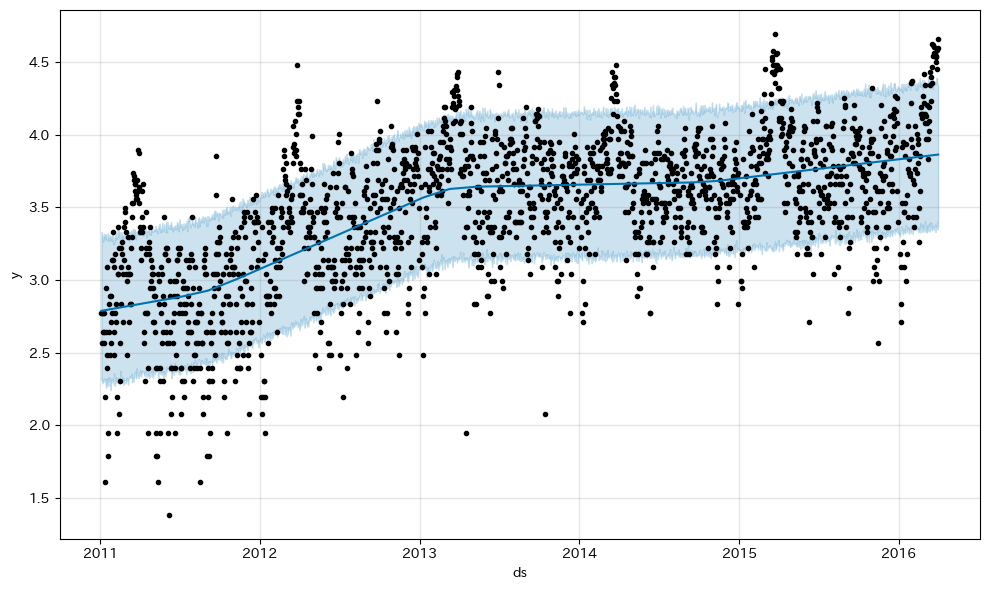

In [5]:
# prophetによる予測結果を可視化
# 訓練データ
forecast_train = model.predict(train_pandas)
fig = model.plot(forecast_train)

del forecast_train
del fig

上手い感じにトレンドを捉えている

In [6]:
# 推定値の算出
forecast_train = pl.Series("y_ln_prophet", model.predict(train_pandas)["yhat"].values)
forecast_test = pl.Series("y_ln_prophet", model.predict(test_pandas)["yhat"].values)

# 推定値をDataFrameにまとめる
train = train.insert_column(4, forecast_train)
test = test.insert_column(3, forecast_test)

# 対数変換した目的変数とProphetによる予測値の差分を計算する
train = train.insert_column(5,
                            (train["y_ln"] - train["y_ln_prophet"]).alias("y_ln_difference")
)

# 不要なDataFrameを削除
del train_pandas
del test_pandas

print(train.head(5))
print(test.head(5))

shape: (5, 9)
┌────────────┬────────────┬─────┬──────────┬────────────┬───────────┬────────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ y_ln     ┆ y_ln_proph ┆ y_ln_diff ┆ client ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---      ┆ et         ┆ erence    ┆ ---    ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ f64      ┆ ---        ┆ ---       ┆ i64    ┆ i64      ┆ i64      │
│            ┆            ┆     ┆          ┆ f64        ┆ f64       ┆        ┆          ┆          │
╞════════════╪════════════╪═════╪══════════╪════════════╪═══════════╪════════╪══════════╪══════════╡
│ 2011-01-04 ┆ 2011-01-04 ┆ 16  ┆ 2.772589 ┆ 2.788082   ┆ -0.015493 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-05 ┆ 2011-01-05 ┆ 16  ┆ 2.772589 ┆ 2.788611   ┆ -0.016022 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-06 ┆ 2011-01-06 ┆ 13  ┆ 2.564949 ┆ 2.78914    ┆ -0.224191 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-07 ┆ 2011-01-07 ┆ 14  ┆ 2.639057 ┆ 2.789669   ┆ -0.150612 ┆ 0      

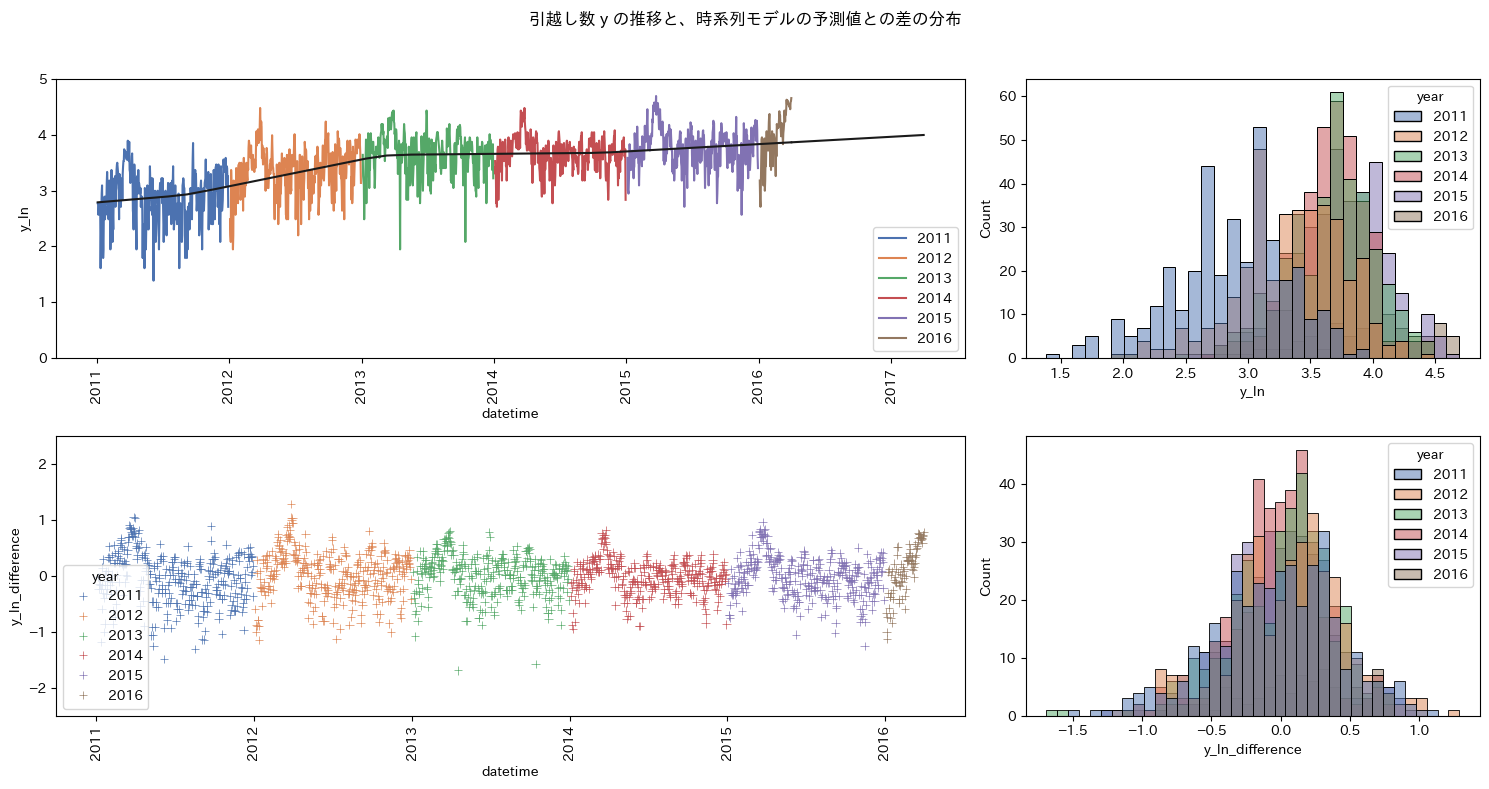

In [7]:
# 様子を可視化
train = train.with_columns(pl.col("datetime").dt.year().alias("year"))
test = test.with_columns(pl.col("datetime").dt.year().alias("year"))

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    height_ratios=[1, 1], width_ratios=[2, 1],
    figsize=(15, 8)
)

g_time_train = sns.lineplot(data = train, x="datetime", y="y_ln", hue="year",palette="deep", ax=axes[0, 0])
g_time_prophet_train = sns.lineplot(data = train, x="datetime", y="y_ln_prophet", color="0.1", ax=axes[0, 0])
g_time_prophet_train = sns.lineplot(data = test, x="datetime", y="y_ln_prophet", color="0.1", ax=axes[0, 0])
g_hist_train = sns.histplot(data = train, x="y_ln", hue="year", palette="deep", ax=axes[0, 1])

g_time_diff_train = sns.scatterplot(data = train, x="datetime", y="y_ln_difference", hue="year", palette="deep", marker="+", ax=axes[1, 0])
g_hist_diff_train = sns.histplot(data = train, x="y_ln_difference", hue="year", palette="deep", ax=axes[1, 1])

# 調整
plt.setp(g_time_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_train, ylim = (0, 5))
plt.setp(g_time_diff_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_diff_train, ylim = (-2.5, 2.5))

plt.suptitle("引越し数 y の推移と、時系列モデルの予測値との差の分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整  
plt.show()

prophetによる予測との差分を取ることで、うまい具合に年ごとの上昇傾向を排除することができた(年ごとの分布を揃えることができた)  
つまり、テストデータ(2016-04-01~2017-03-31)と訓練データ(2011-01-01 ~ 2016-03-31)における目的変数の確率分布が等しいとみなせるようになった  
これにより、LGBMなどの強力な予測精度が安定することが期待される  

最終的な提出データは、  
1. y_ln_differenceをLGBM等適当なモデルに予測させて、
2. それをprohetによるy_lnのベースラインに足す。
3. 対数変換の逆変換によってy_lnをyに戻す
4. 退避させていたclose=1のデータを戻す
5. 完成

といった感じ

## 学習と予測

In [8]:
# 機械学習ライブラリと親和性の高いPandasに変換する
train_pandas = train.to_pandas().set_index("id")

# 目的変数と特徴量
target_column = "y_ln_difference"
feature_columns = ["client", "price_am", "price_pm"]

# 今回は時系列予測なので、訓練データと評価データを分割する際に、時系列の順番を考慮する必要がある
# 今回は、2015年1月1日を境に訓練データと評価データを分割する
# 訓練データと検証データを期間で分割
train_temp = train_pandas[train_pandas["datetime"] < "2015-01-01"]
valid_temp = train_pandas[train_pandas["datetime"] >= "2015-01-01"]

# 説明変数と目的変数を分割
X_train, y_train = train_temp[feature_columns], train_temp[target_column]
X_valid, y_valid = valid_temp[feature_columns], valid_temp[target_column]

# 学習
model = GradientBoostingRegressor(random_state = 1192).fit(X_train, y_train)

# 予測(モデルの予測値をベースラインであるy_ln_prophetに足した後、対数変換を逆変換)
y_pred_train = np.exp(model.predict(X_train) + train_temp["y_ln_prophet"])
y_pred_valid = np.exp(model.predict(X_valid) + valid_temp["y_ln_prophet"])

# 予測精度の確認
print("訓練データの評価関数:", np.round(mean_absolute_error(train_temp["y"], y_pred_train), decimals = 7))# 小数第7位はコンペスコアの有効数字
print("評価データの評価関数:", np.round(mean_absolute_error(valid_temp["y"], y_pred_valid), decimals = 7))

訓練データの評価関数: 6.4137964
評価データの評価関数: 11.0827593


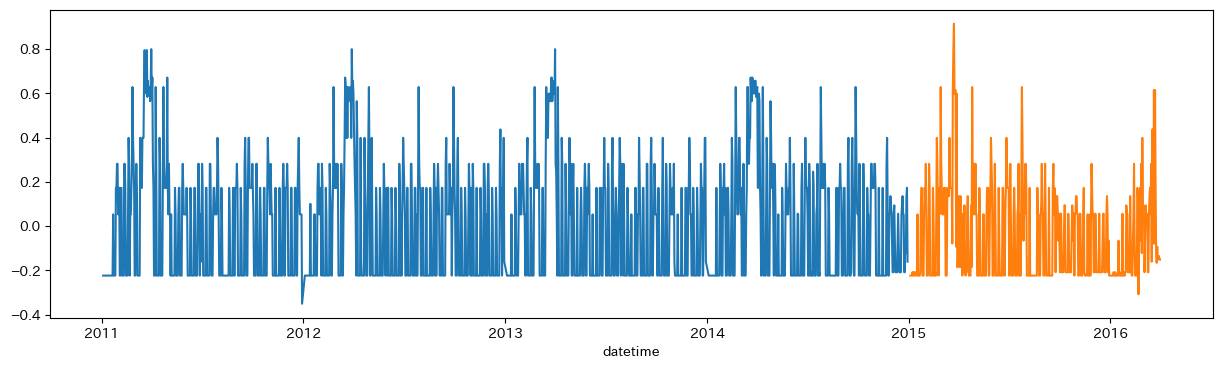

In [9]:
# モデルによる予測
fig, ax = plt.subplots(figsize=(15, 4))
g_time_train = sns.lineplot(data = train_temp, x="datetime", y=model.predict(X_train), ax=ax)
g_time_train = sns.lineplot(data = valid_temp, x="datetime", y=model.predict(X_valid), ax=ax)
plt.show()

何故か-0.2より小さい値の予測が殆どない

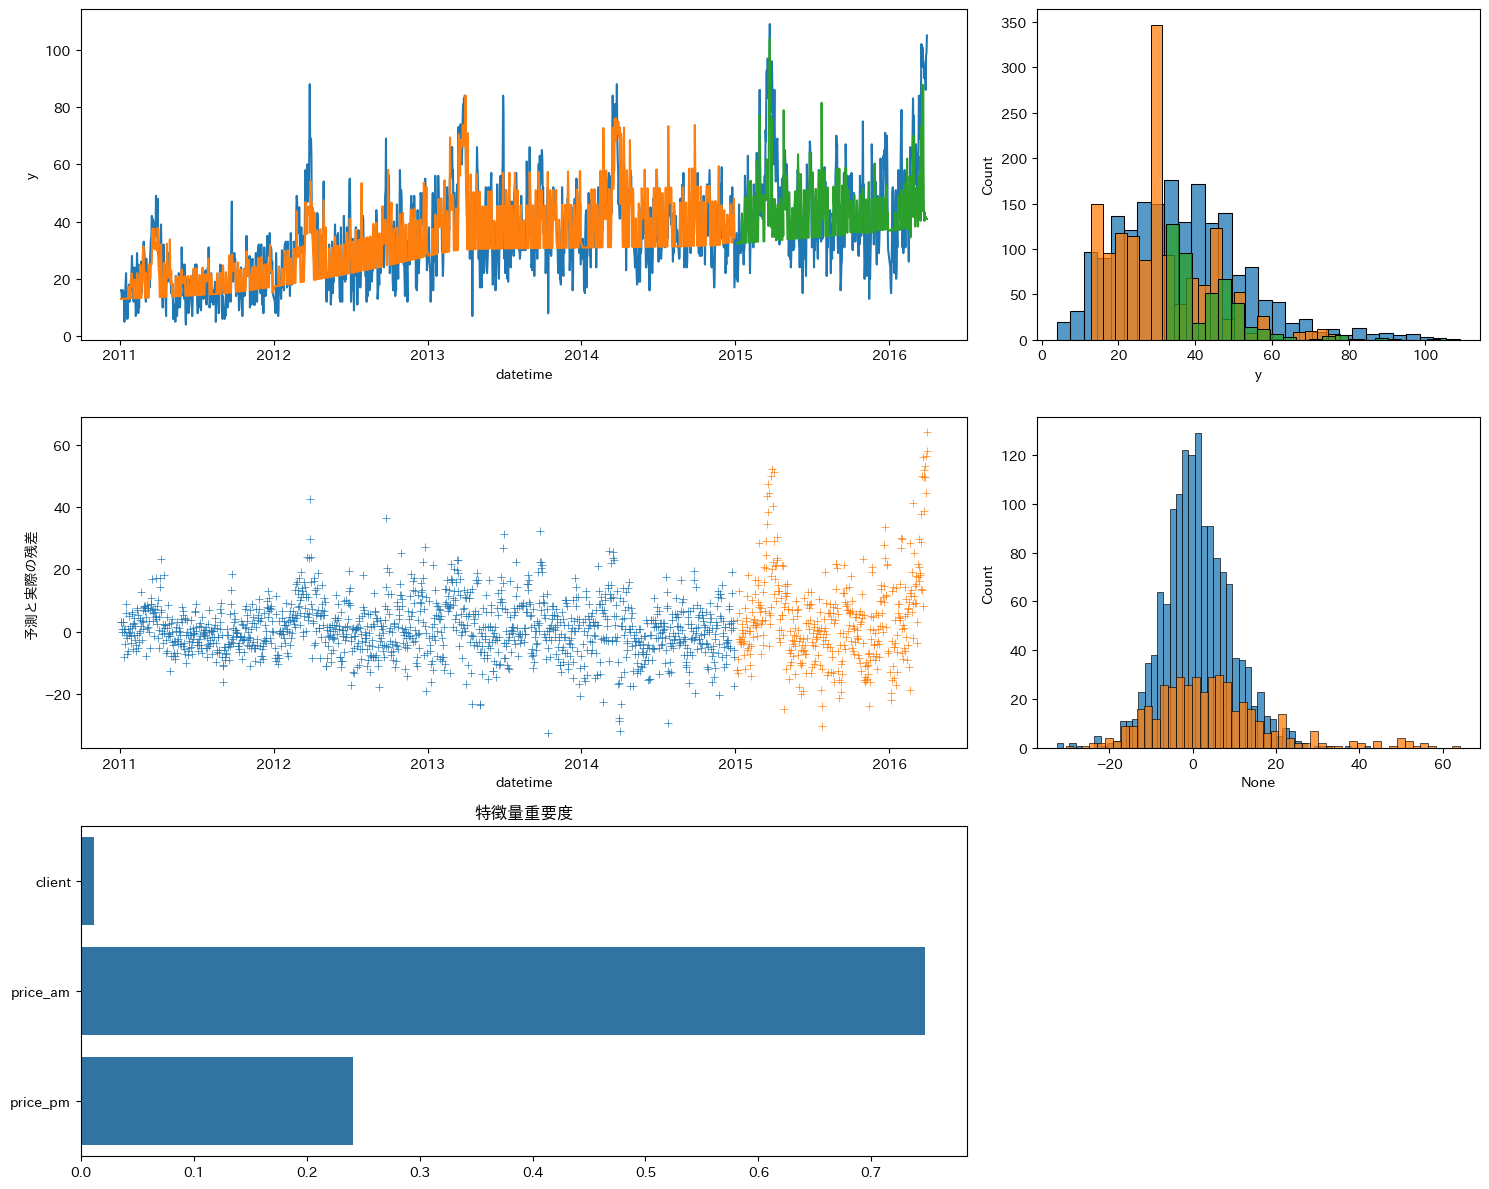

In [10]:
# 可視化
fig, axes = plt.subplots(
    nrows=3, ncols=2,
    height_ratios=[1, 1, 1], width_ratios=[2, 1],
    figsize=(15, 12)
)

g_time_train = sns.lineplot(data = train_pandas, x="datetime", y="y", ax=axes[0, 0])
g_predict_train = sns.lineplot(data = train_temp, x="datetime", y=y_pred_train, ax=axes[0, 0])
g_predict_valid = sns.lineplot(data = valid_temp, x="datetime", y=y_pred_valid, ax=axes[0, 0])

g_time_hist_train = sns.histplot(data = train_pandas, x="y", ax=axes[0, 1])
g_predict_hist_train = sns.histplot(data = train_temp, x=y_pred_train, ax=axes[0, 1])
g_predict_hist_valid = sns.histplot(data = valid_temp, x=y_pred_valid, ax=axes[0, 1])

# 残差の確認
g_diff_train = sns.scatterplot(data = train_temp, x="datetime", y=train_temp["y"] - y_pred_train, marker = "+", ax=axes[1, 0])
g_diff_valid = sns.scatterplot(data = valid_temp, x="datetime", y=valid_temp["y"] - y_pred_valid, marker = "+", ax=axes[1, 0])
axes[1, 0].set_ylabel("予測と実際の残差")

g_hist_diff_train = sns.histplot(data = train_temp, x=train_temp["y"] - y_pred_train, bins=50, ax=axes[1, 1])
g_hist_diff_valid = sns.histplot(data = valid_temp, x=valid_temp["y"] - y_pred_valid, bins=50, ax=axes[1, 1])

# 特徴量重要度
g_importance = sns.barplot(x=model.feature_importances_, y=feature_columns, ax=axes[2, 0])
g_importance.set_title("特徴量重要度")

axes[2, 1].axis("off")

plt.tight_layout()

del train_temp, valid_temp
del X_train, y_train, X_valid, y_valid
del y_pred_train, y_pred_valid

上昇傾向は上手く捉えられている(prophetのおかげかな)  
実際、残差の分布については何とか揃えられている  
引っ越し数yが低い場所が上手く予測できていない。何だか、下限が一つの曲線で抑えられてしまっている？  
改めて、やっぱ特徴量が少なすぎる。もっといろいろ増やそう

## 提出データ出力

In [11]:
# 提出前に、全ての訓練データを使って学習させておく
X, y = train_pandas[feature_columns], train_pandas[target_column]
model = GradientBoostingRegressor(random_state = 1192).fit(X, y)

# 機械学習ライブラリと親和性の高いPandasに変換する
test_pandas = test.to_pandas().set_index("id")

# 説明変数の分割
X_test = test_pandas[feature_columns]

# 予測
y_pred_test = np.exp(model.predict(X_test) + test_pandas["y_ln_prophet"])

# 提出用DataFrame
submit = pl.DataFrame({
    "id": X_test.index.values,
    "y": y_pred_test.values
})

# 退避していた休業日のデータを結合
submit = pl.concat(
    [submit, test_close],
    how = "vertical_relaxed"
).sort("id")

# 提出ファイルを保存する
# submit.write_csv("../data/output/submit_original_features_gbt_default_prm.csv", include_header = False)

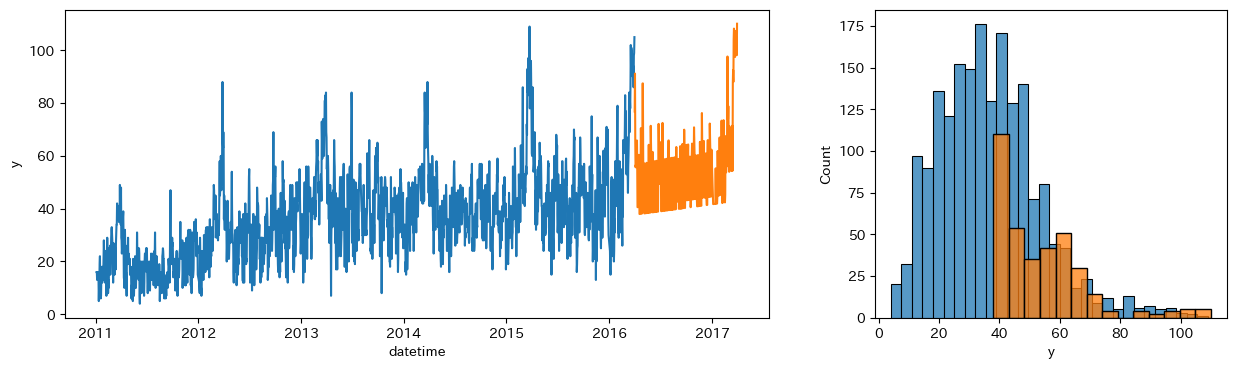

In [12]:
# テストデータに対する予測の可視化
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    height_ratios=[1], width_ratios=[2, 1],
    figsize=(15, 4)
)

g_time_train = sns.lineplot(data = train_pandas, x="datetime", y="y", ax=axes[0])
g_time_test = sns.lineplot(data = test_pandas, x="datetime", y=y_pred_test, ax=axes[0])

g_hist_train = sns.histplot(data = train_pandas, x="y", ax=axes[1])
g_hist_test = sns.histplot(data = test_pandas, x=y_pred_test, ax=axes[1])

うーん…。やはり引っ越し数が低いところの予測が全然できていない。改善が必要だろう

# 参考サイト  
[コンペサイト アップル 引越し需要予測](https://signate.jp/competitions/269/data)  
[SIGNATE SOTA アップル 引越し需要予測 備忘録](https://zenn.dev/tremendous1192/articles/ea6e73359ee764)  


# メモ

- 学習データからあまりに離れた期間の予測は精度が低くなると思う
  - 精々1年後程度？そのため、新しい学習データを適宜ちゃんと入れてあげる必要あり
- 何故引っ越し数が低いところが上手く予測できなかったのかは結局よくわからん
- ラグ特徴量も入れてみたいな。◯◯日前のyの値とかさ

In [13]:
# 退避。今回は時系列予測なのでこの分割は不適切なはず

# # 今回はy, y_ln_prophetといった元のカラムも一緒に分割したいので、train_test_split関数は使わない
# # 訓練データと評価データに分割するマスク
# np.random.seed(1192)
# train_mask_1 = np.random.choice([True, False], size = len(train_pandas), p = [0.75, 0.25])

# # 説明変数、目的変数の分割
# # y_train, y_validと書いてはいるが、これは「引っ越し数y」のことではなく「学習時の目的変数としてのy」を表しており
# # つまりy_ln_differenceのことであることに注意
# train_temp, valid_temp = train_pandas[train_mask_1], train_pandas[~train_mask_1]
# X_train, y_train = train_temp[feature_columns], train_temp[target_column] 
# X_valid, y_valid = valid_temp[feature_columns], valid_temp[target_column]